In [1]:
library(devtools)
library(metacell)
load_all("../metacell.flow/")
scdb_init("scdb/",force_reinit = T)
scfigs_init("figs")
scdb_flow_init()

Loading required package: usethis

i Loading metacell.flow

initializing scdb to ../../oc_mm_gastru_amos/scdb/



In [2]:
fig_dir = "figs"
plot_pdf = T
bg = "white"
# focals = c("Early nascent mesoderm", "Late nascent mesoderm", "Epiblast", "Primitive streak")
# focals = c("Primitive streak")
oc_focals = c("epiblast")
# focals = c("nascent mesoderm")

oc_mc = scdb_mc("oc_emb")

oc_mat = scdb_mat("oc_emb")

oc_md = oc_mat@cell_metadata



In [3]:
oc_md = oc_mat@cell_metadata
oc_md[oc_md$embryo=='Rab5_e6_Anterior',]$embryo = "Rab5_e6"
oc_md[oc_md$embryo=='Rab5_e6_Posterior',]$embryo = "Rab5_e6"
oc_md[oc_md$embryo=='Rab8_e6_Anterior',]$embryo = "Rab8_e6"
oc_md[oc_md$embryo=='Rab8_e6_Posterior',]$embryo = "Rab8_e6"
oc_md[oc_md$embryo=='Rab8_e6_Trunk',]$embryo = "Rab8_e6"
oc_md[oc_md$embryo=='0824e4_anterior',]$embryo = "0824e4"
oc_md[oc_md$embryo=='0824e4_posterior',]$embryo = "0824e4"
oc_md[oc_md$embryo=='0824e4_middle',]$embryo = "0824e4"
oc_md[oc_md$embryo=='Rab15_e1_head',]$embryo = "Rab15_e1"
oc_md[oc_md$embryo=='Rab15_e1_midAnt',]$embryo = "Rab15_e1"
oc_md[oc_md$embryo=='Rab15_e1_midPost',]$embryo = "Rab15_e1"
oc_md[oc_md$embryo=='Rab15_e1_tail',]$embryo = "Rab15_e1"

### Smoothing the time curve
#### Linear interpolation

In [4]:
library(zoo)


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric




In [5]:
oc_mc_col_by_mm = fread("oc_mc_col_by_mm.csv")

In [6]:
oc_mc_col_by_mm = oc_mc_col_by_mm[order(oc_mc_col_by_mm$name),]

In [7]:
mm_focals = c("Epiblast")
mm_mc = scdb_mc("mm_emb")

mm_mat = scdb_mat("mm_emb")

mm_md = mm_mat@cell_metadata

mm_mc_emb = scdb_mc("mm_embemb")
mm_type_ag = table(mm_mc_emb@colors[mm_mc_emb@mc], mm_md[names(mm_mc_emb@mc),"age_group_emb"])

mm_type_agn = t(t(mm_type_ag)/colSums(mm_type_ag))

In [8]:
oc_type_ag = table(factor(x = oc_mc_col_by_mm$value[oc_mc@mc],levels = rownames(mm_type_agn)), oc_md[names(oc_mc@mc),"chunk"])

oc_type_agn = t(t(oc_type_ag)/colSums(oc_type_ag))

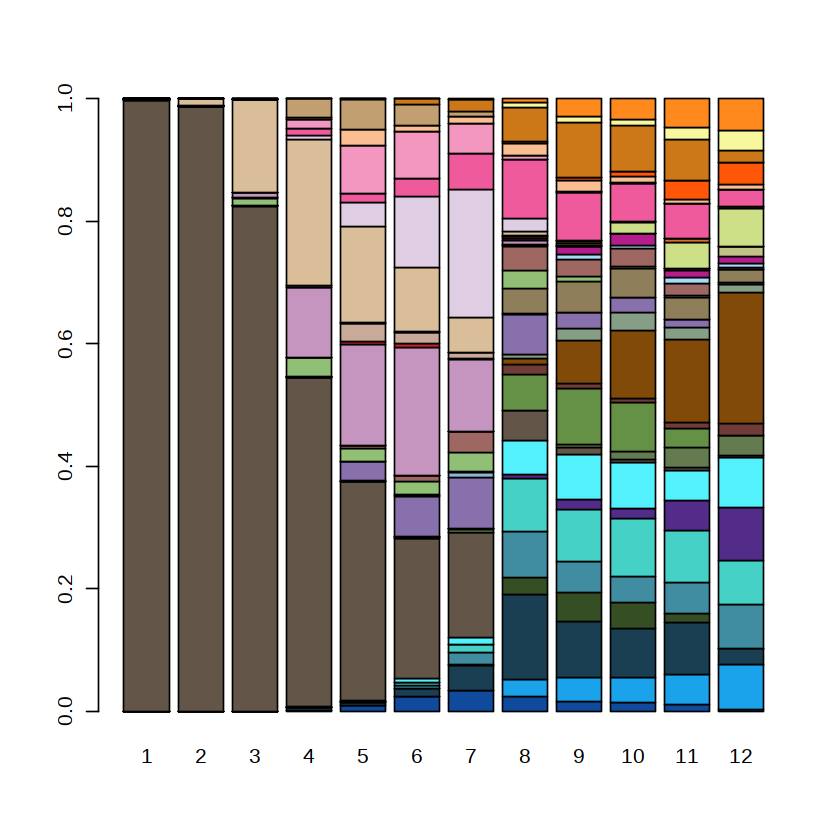

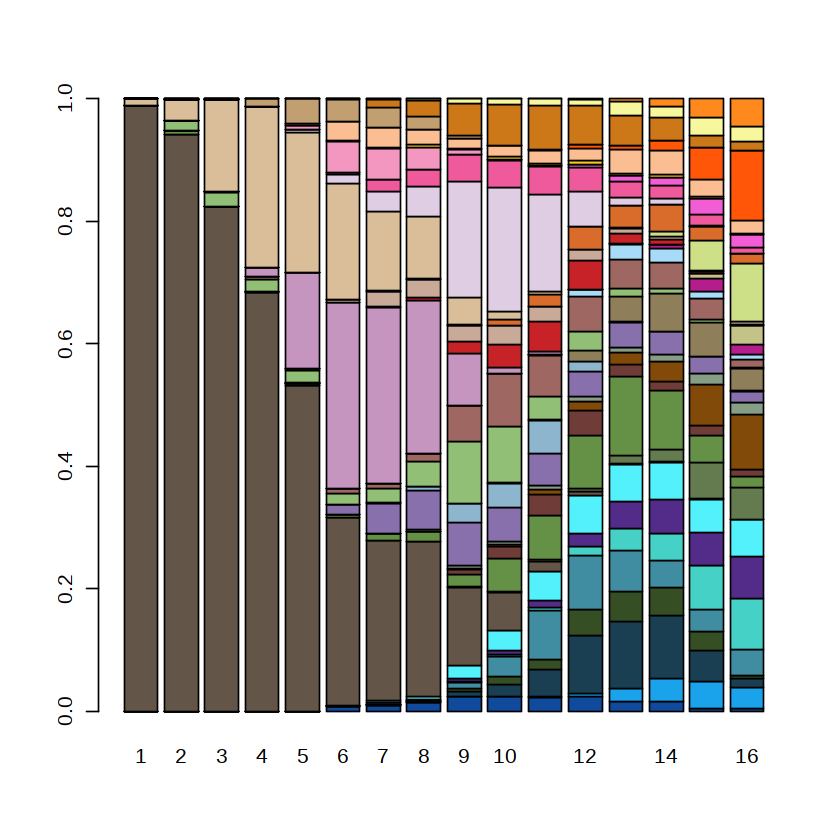

In [9]:
barplot(oc_type_agn,col = rownames(oc_type_agn))
barplot(mm_type_agn,col = rownames(mm_type_agn))

In [11]:
mm_times = fread("../../oc_mm_gastru_amos/mm_embs_grouping.txt")
oc_times = fread("../../oc_mm_gastru_amos/oc_embs_grouping.txt")[c("chunk", "gt")] %>% group_by(chunk) %>% summarise(developmental_time = mean(gt)) %>% rename(age_group=chunk)

In [12]:
oc_ex = apply(oc_type_agn,1,function(v) {
    approx(x = oc_times$developmental_time,y = v,n = 1000)$y
})
rownames(oc_ex) = approx(x = oc_times$developmental_time,y = oc_type_agn[1,],n = 1000)$x

In [13]:
mm_ex = apply(mm_type_agn,1,function(v) {
    approx(x = mm_times$developmental_time,y = v,n = 1000)$y
})
rownames(mm_ex) = approx(x = mm_times$developmental_time,y = mm_type_agn[1,],n = 1000)$x

In [14]:
mm_ex = mm_ex[rownames(mm_ex)[rownames(mm_ex) >= max(min(rownames(mm_ex)),min(rownames(oc_ex)))],]
oc_ex = oc_ex[rownames(oc_ex)[rownames(oc_ex) >= max(min(rownames(mm_ex)),min(rownames(oc_ex)))],]
mm_ex = mm_ex[rownames(mm_ex)[rownames(mm_ex) <= min(max(rownames(mm_ex)),max(rownames(oc_ex)))],]
oc_ex = oc_ex[rownames(oc_ex)[rownames(oc_ex) <= min(max(rownames(mm_ex)),max(rownames(oc_ex)))],]

In [15]:
mm_oc_cor = tgs_cor(as.matrix(as.data.frame.matrix(t(oc_ex))),as.matrix(as.data.frame.matrix(t(mm_ex))))

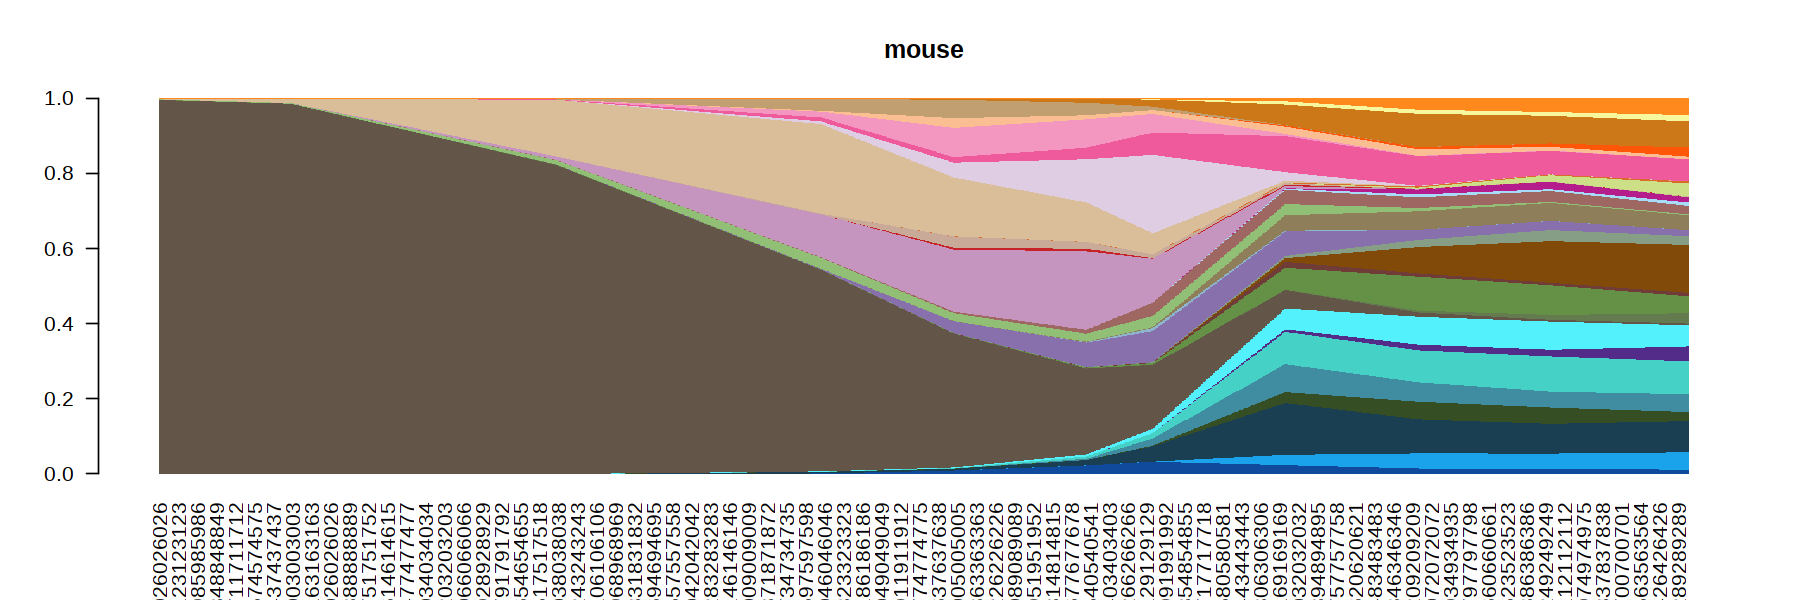

In [16]:
options(repr.plot.width=15, repr.plot.height=5)
# pdf("rabbit_inter_freq_plot.pdf", width=30, height=5)
barplot(t(oc_ex),col = rownames(t(oc_ex)), border=NA, las=2, main="mouse", space=0)
# dev.off()

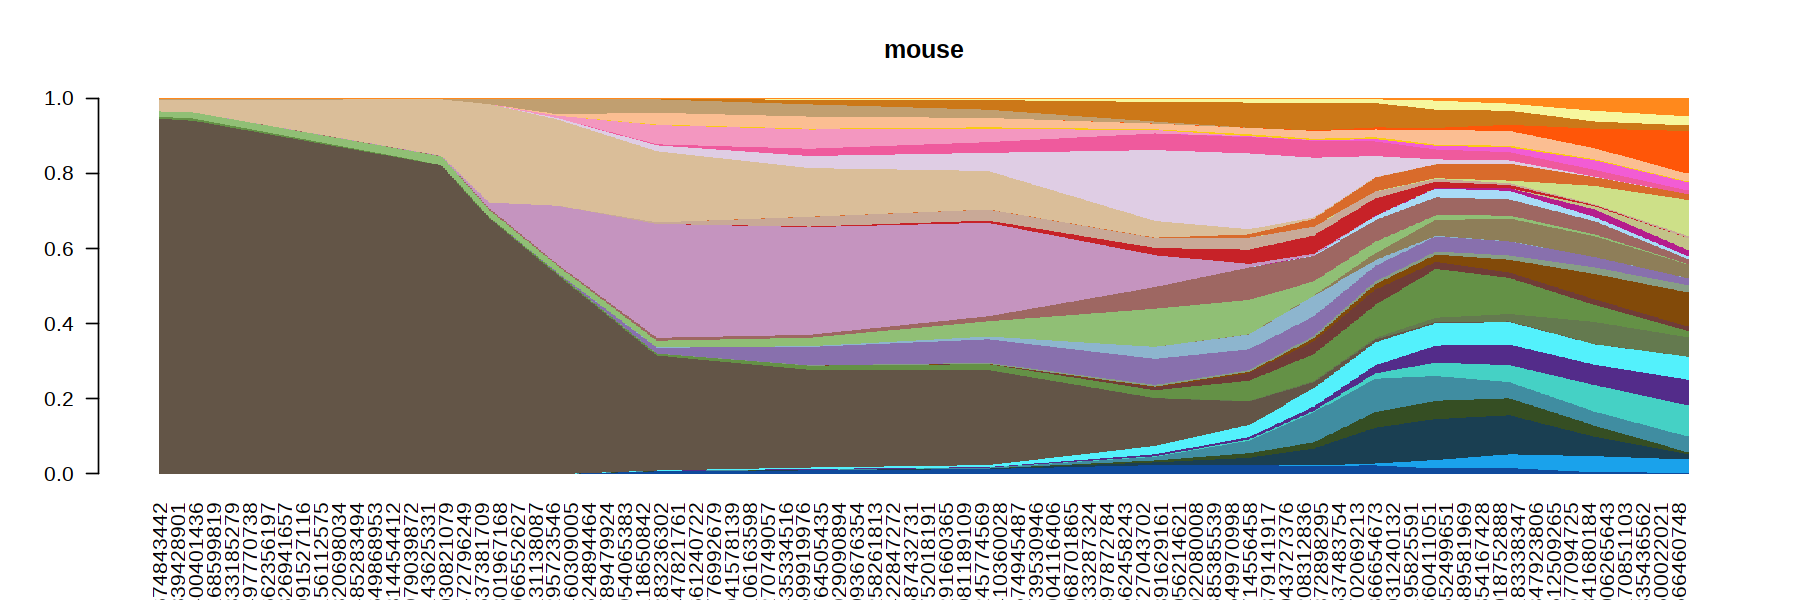

In [17]:
options(repr.plot.width=15, repr.plot.height=5)
# pdf("mouse_inter_freq_plot.pdf", width=30, height=5)
barplot(t(mm_ex),col = rownames(t(mm_ex)), border=NA, las=2, main="mouse", space=0)
# dev.off()

In [18]:
write.csv(oc_ex, "fig5a_oc_freq.csv")
write.csv(mm_ex, "fig5a_mm_freq.csv")

In [19]:
fwrite(mm_mc_emb@color_key, "fig5a_colorkey.csv")

In [20]:
save_pheatmap_pdf <- function(x, filename, width=7, height=7) {
    stopifnot(!missing(x))
    stopifnot(!missing(filename))
    pdf(filename, width=width, height=height)
    grid::grid.newpage()
    grid::grid.draw(x$gtable)
    dev.off()
}

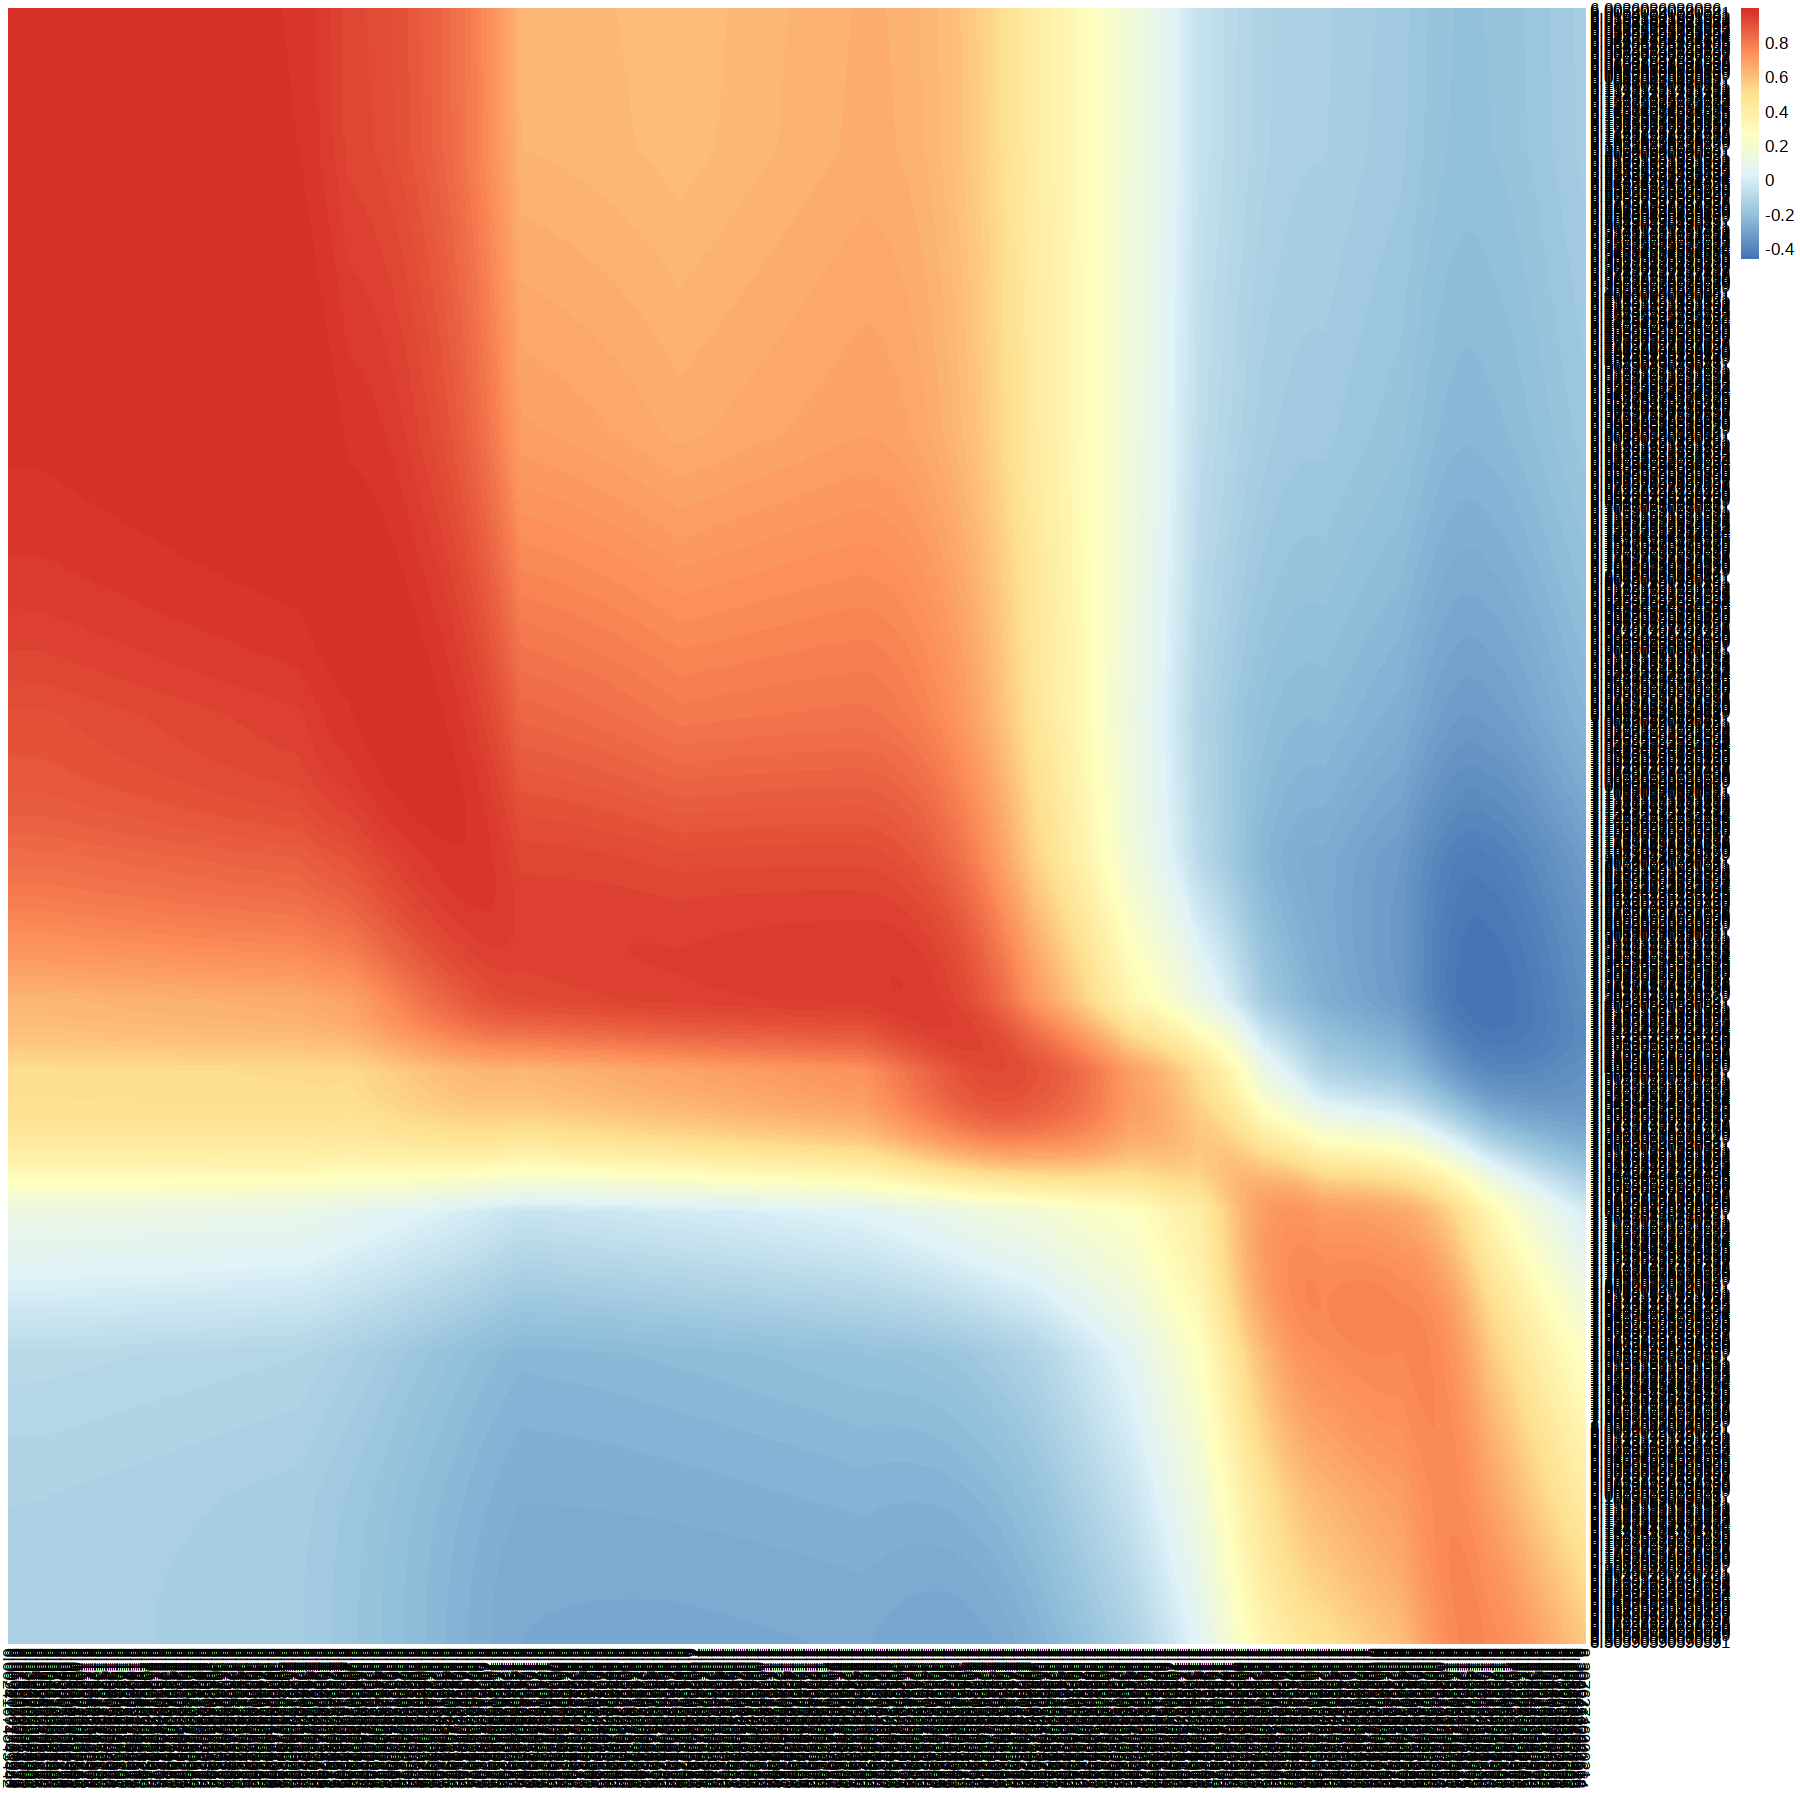

In [21]:
options(repr.plot.width=15, repr.plot.height=15)
# paletteLength = 1000
# myColor <- colorRampPalette(c("blue", "white", "red"))(paletteLength)
# myBreaks <- c(seq(-1, 0.0, length.out=ceiling(paletteLength/2)),
#               seq(0.01, 1, ength.out=ceiling(paletteLength/2)))
ph = pheatmap::pheatmap(mm_oc_cor,cluster_rows = F,cluster_cols = F, 
#                    color = myColor, breaks = myBreaks
                  )
# save_pheatmap_pdf(ph,paste0("fig5A.pdf"), width=12, height=10)

In [22]:
cost = 1-mm_oc_cor

In [23]:
library(dtw)

Loading required package: proxy


Attaching package: 'proxy'


The following object is masked from 'package:metacell.flow':

    as.matrix


The following objects are masked from 'package:stats':

    as.dist, dist


The following object is masked from 'package:base':

    as.matrix


Loaded dtw v1.23-1. See ?dtw for help, citation("dtw") for use in publication.




In [24]:
dtw_map = dtw(x = cost)

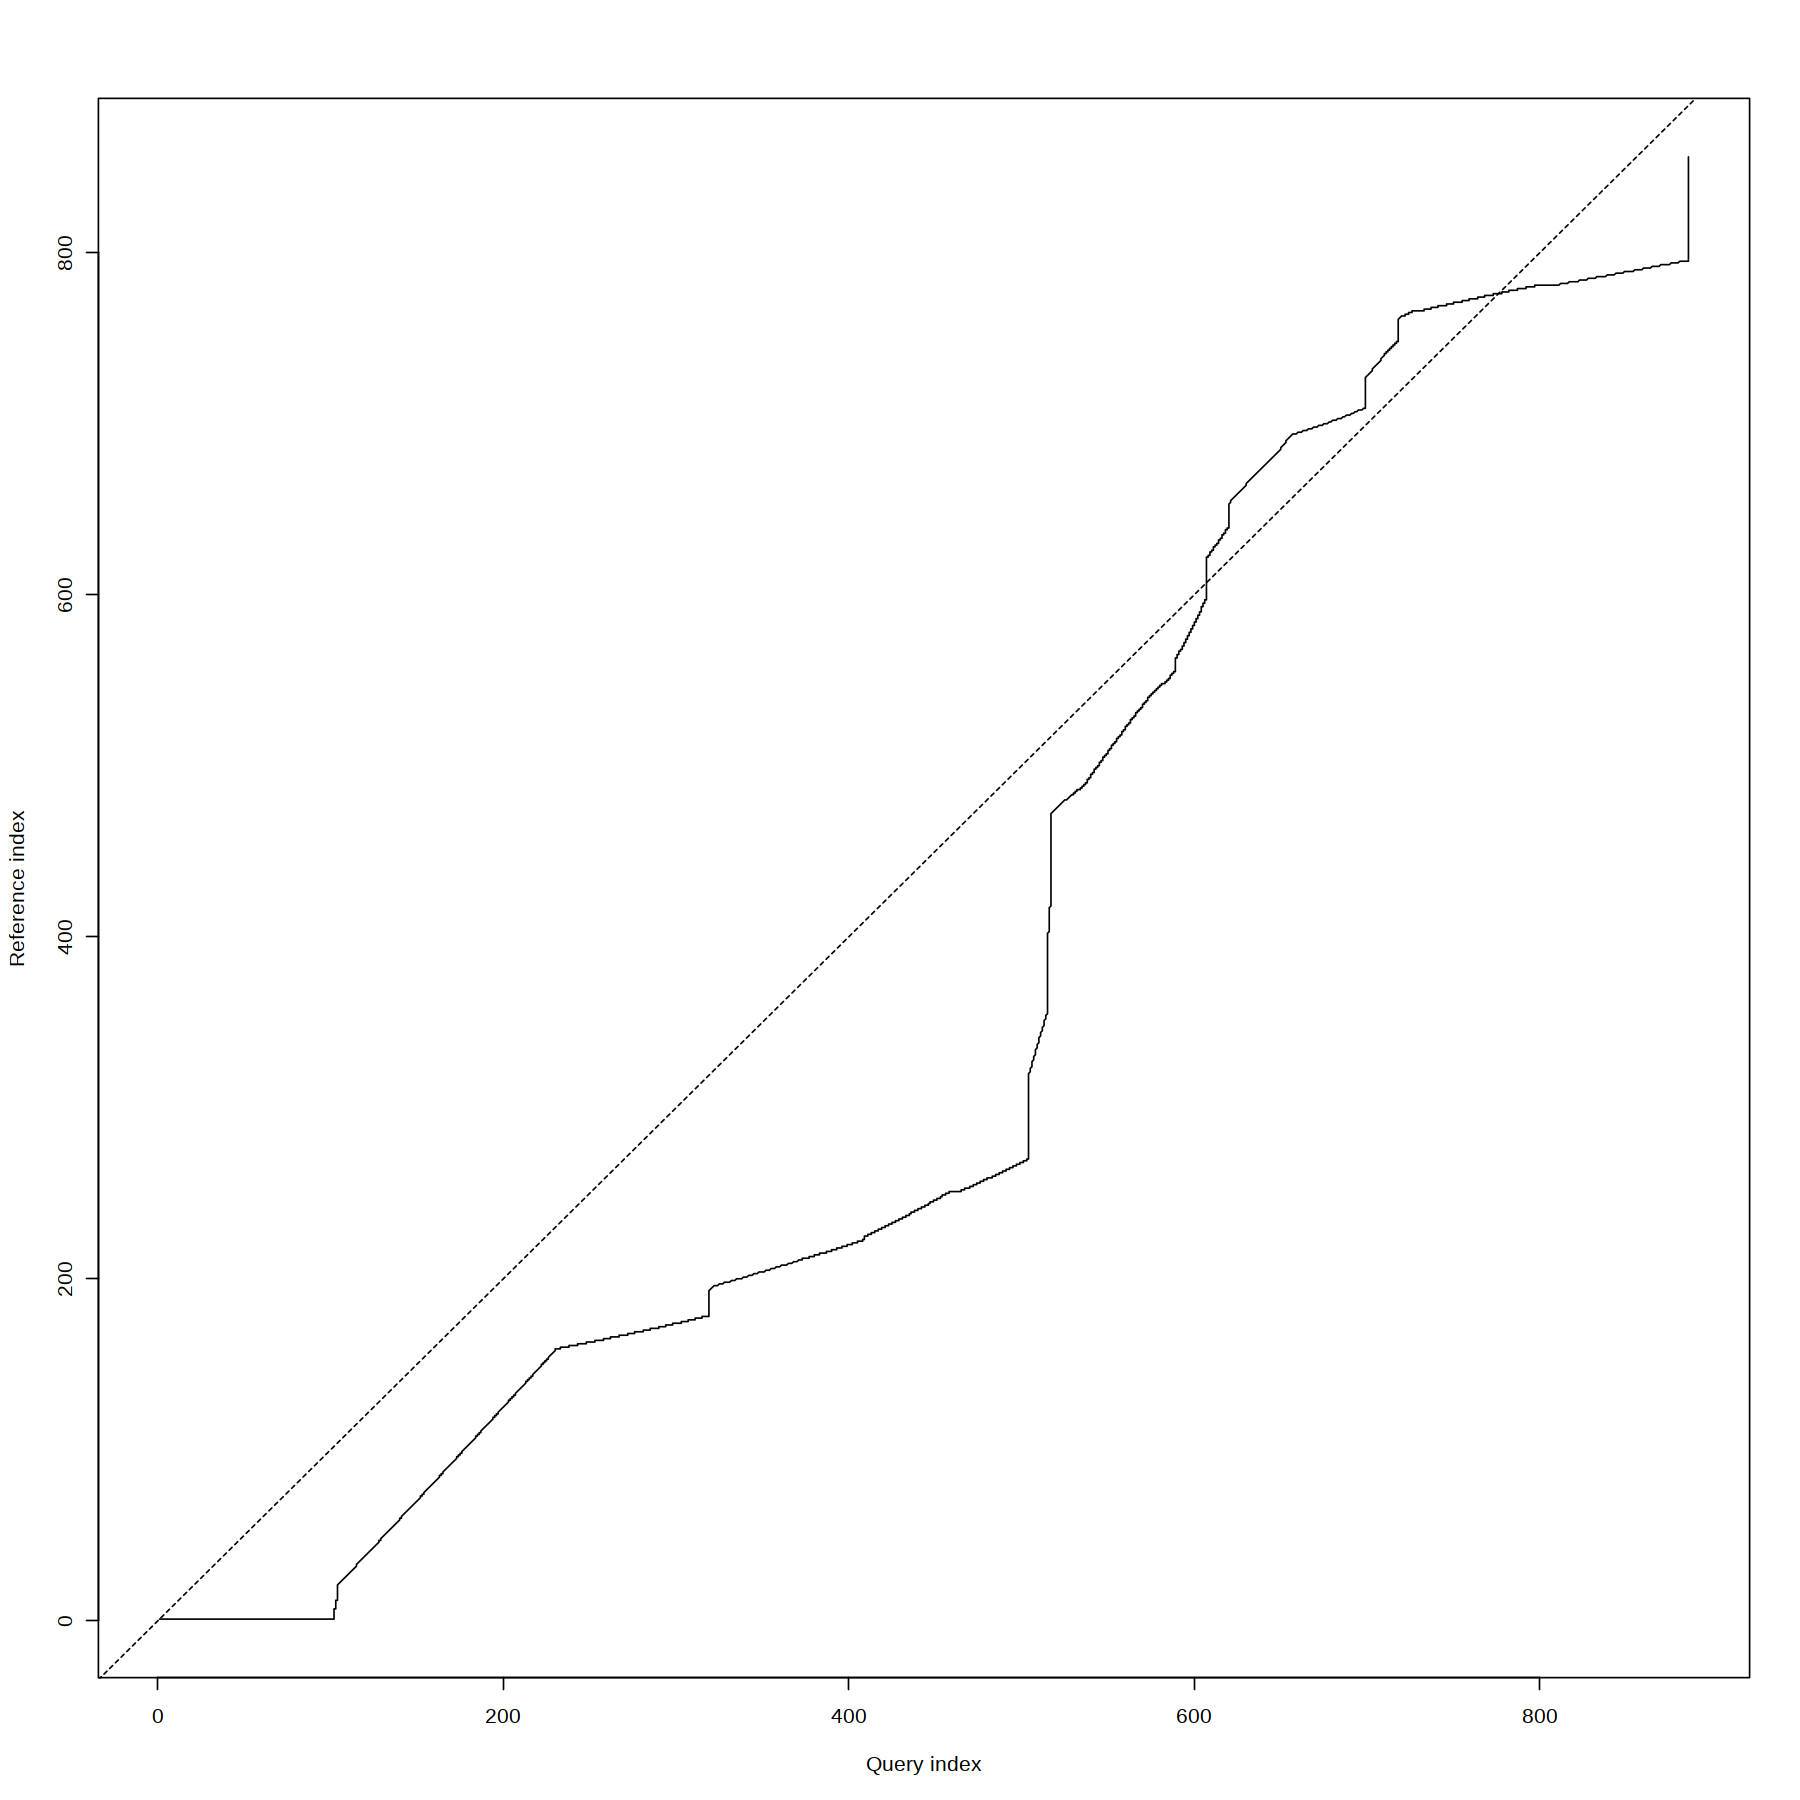

In [25]:
options(repr.plot.width=15, repr.plot.height=15)
# pdf("dtw.pdf", width=15, height=15)
plot(dtw_map)
abline(a = 0,b= 1, lt="dashed")
# dev.off()

In [26]:
m = matrix(0, nrow = dim(cost)[1], ncol = dim(cost)[2])
for(i in 1:(length(dtw_map$index1)-1)){
    m[dtw_map$index1[i], dtw_map$index2[i]] = 1
    m[dtw_map$index1[i], dtw_map$index2[i]+1] = 1
}

In [27]:
cors_along = c()
for(i in 1:(length(dtw_map$index1)-1)){
    cors_along = c(cors_along, mm_oc_cor[dtw_map$index1[i], dtw_map$index2[i]])
    }

In [28]:
k = 81
mouse_time = as.numeric(rownames(mm_ex))
rabbit_time = as.numeric(rownames(oc_ex))

mouse_time_smooth = rollmean(mouse_time[dtw_map$index2],k = k)
mouse_index_smooth = rollmean(dtw_map$index2,k = k)

derivative_smooth = rollapply(c(1:length(dtw_map$index2)),width = k,FUN = function(i_indices) {
    
    max_mm_time = mouse_time[dtw_map$index2[i_indices[k]]]
    min_mm_time = mouse_time[dtw_map$index2[i_indices[1]]]
    max_oc_time = rabbit_time[dtw_map$index1[i_indices[k]]]
    min_oc_time = rabbit_time[dtw_map$index1[i_indices[1]]]
    
    oc_mm_derivative = (max_oc_time - min_oc_time)/(max_mm_time - min_mm_time)
    
})





In [29]:
spline_smooth = smooth.spline(x = mouse_time[dtw_map$index2],y = rabbit_time[dtw_map$index1],spar = 0.4)

Warning message in plot.xy(xy, type, ...):
"plot type 'line' will be truncated to first character"


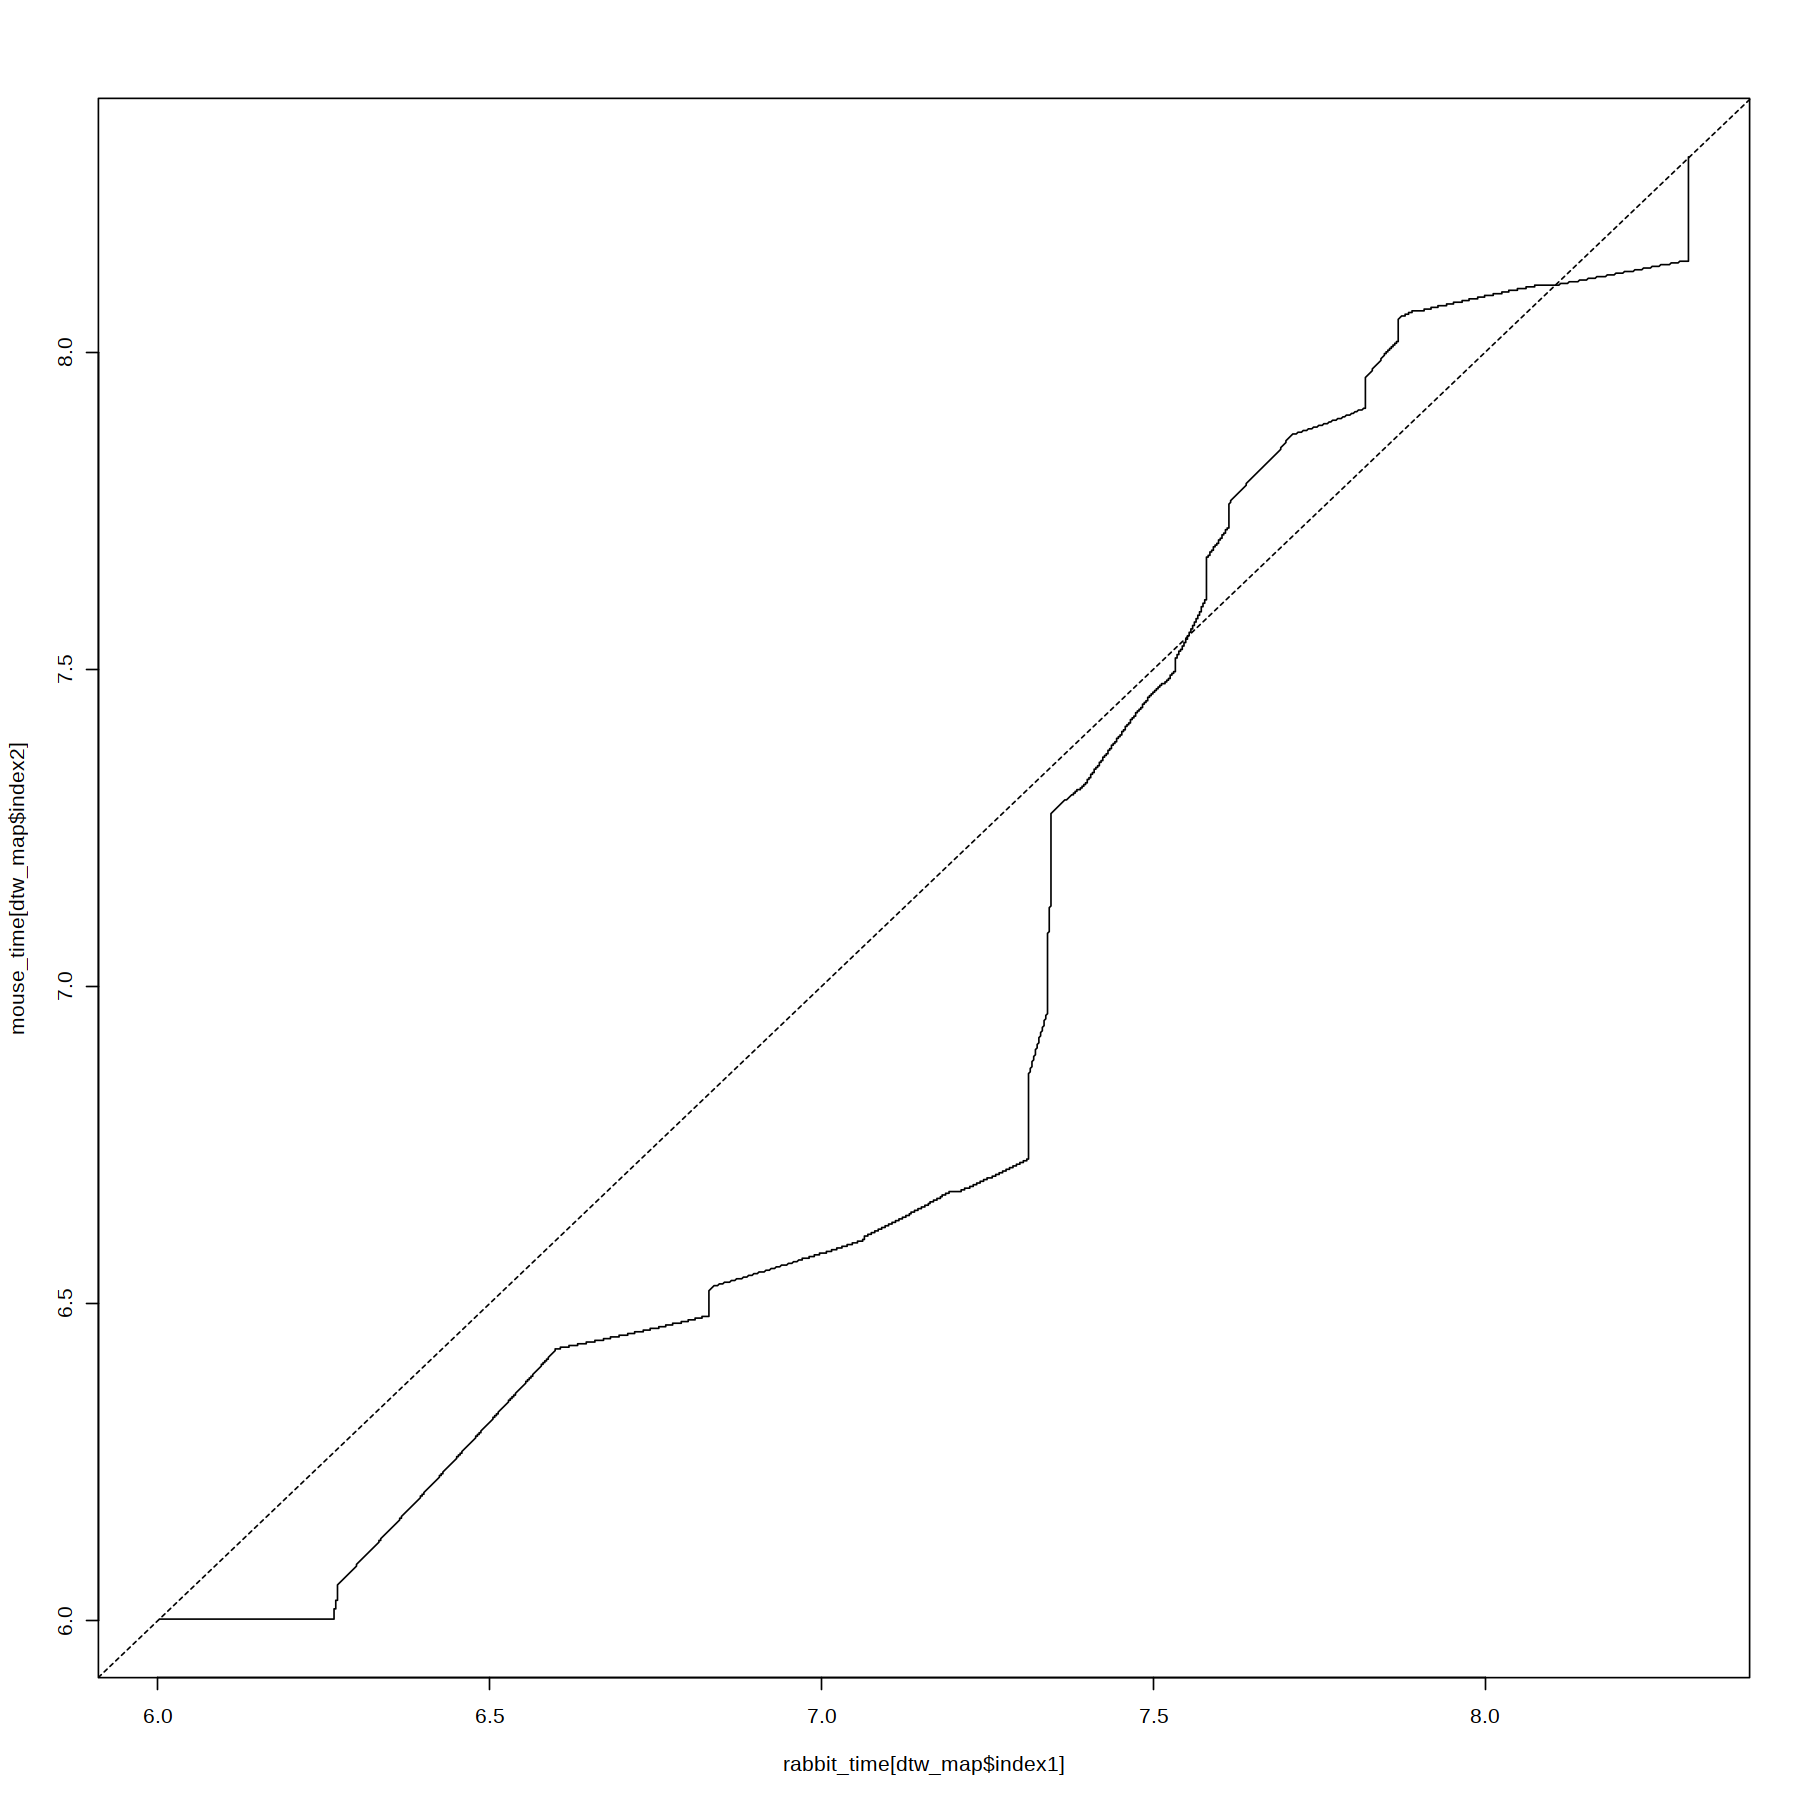

In [30]:
par(bg=NA)
# png("test_dtw.png", bg="transparent")
plot(x = rabbit_time[dtw_map$index1],y = mouse_time[dtw_map$index2], type="line")
abline(a=0, b=1, lt="dashed")
# dev.off()
# plot(x = spline_smooth$x,spline_smooth$y, type="line")

In [31]:
oc_mm_derivative = diff(spline_smooth$y)/diff(spline_smooth$x)

Warning message in plot.xy(xy, type, ...):
"plot type 'line' will be truncated to first character"


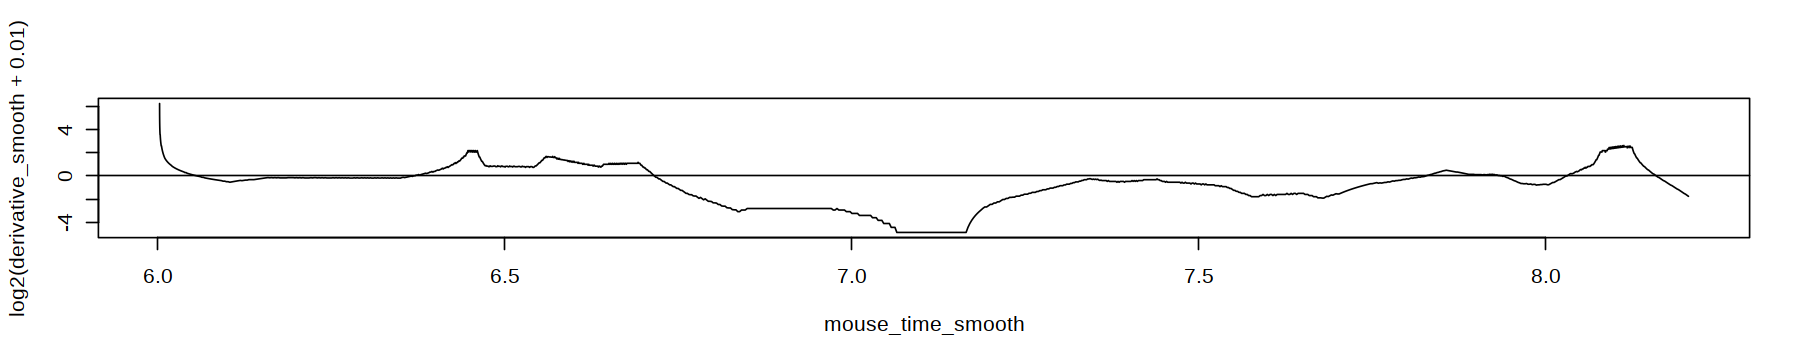

In [32]:
options(repr.plot.width=15, repr.plot.height=3)
# pdf("dtw_deriv.pdf", width=15, height=3)
plot(x = mouse_time_smooth,y = log2(derivative_smooth + 0.01), type="line")
abline(h = 0)
# dev.off()